# 1. 세팅 - mount, install, import, read

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pandas
!pip install konlpy
!pip install sklearn
!pip install plotly

     |████████████████████████████████| 19.4 MB 3.9 MB/s 
     |████████████████████████████████| 86 kB 5.2 MB/s 
     |████████████████████████████████| 448 kB 50.0 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import pandas as pd
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 시 데이터 불러오기
poem = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nlp3/data/nlp_poem.csv", index_col=False)
poem.head()


,author,title,content
0,문정희,가을 노트,<br><br><br>그대 떠나간 후<br>나의 가을은<br>조금만 건드려도<br>...
1,이순,가을비 오는 날은,<br>자정이 되어 간신히 그치는 비<br>간신히 버리는 그리움<br>그동안 너무 ...
2,이성선,가을 편지,<br>잎이 떨어지고 있습니다<br>원고지처럼 하늘이 한 칸씩<br>비어 가고 있습...
3,박제영,가을에는,<br>가을에는 잠시 여행을 떠날 일이다<br>그리 수선스러운 준비는 하지 말고<b...
4,최영미,가을에는,<br>내가 그를 사랑한 것도 아닌데<br>미칠 듯 그리워질 때가 있다<br>바람의...


# 2. 데이터 전처리

In [ ]:
# 불용어
stopwords = [
    '하다', '이다', '아니다', '않다', '되다', '있다', '없다', '싶다', '알다', '보다', '마다', '같다', '지다', '가다', '오다', '두다',
    '나', '내', '날', '난', '제', '너', '네', '널', '넌', '그대', '당신', '우리', '이', '그', '저', '무엇', '이런', '저런', '그런', '것', '게', '건', '거기',
    '하나', '모든', '때문', '다음', '위해', '사람', '줄', '못', '그리다', '되어다', '수', '사랑', '말', '안', '속', '때', '머', '알', '또', '번', '왜', '뿐', '듯', '채', '곳', '선', '오', '이오'
]

In [ ]:
# 토큰화 함수
def tokenize(text):
    okt = Okt()

    # 줄바꿈(<br>) 제거
    text = text.replace("<br>", " ")

    # 형태소(품사) 분석 - 정규화有, 어간추출有
    okt_pos = okt.pos(text, norm=True, stem=True)

    # 특정 품사(명사, 동사, 형용사)만 사용
    lst_word = [word for word, pos in okt_pos if pos in ["Noun", "Adjective", "Verb"]]

    # 불용어 제거
    lst_word = [word for word in lst_word if word not in stopwords]

    # list를 이어 string으로 반환
    str_word = " ".join(lst_word)

    return str_word


In [ ]:
# 시 내용에 토큰화 적용
content = poem["content"]
content_tokens = content.apply(tokenize)
content_tokens.head()

0    떠나가다 후 가을 조금 건드리다 우수수 몸 떨다 다한 다한 노래 끄다 씨앗 가슴 담...
1    자정 그치다 비 버리다 그리움 그동안 많다 버리다 허다 세월 지나 돌아보다 버리다 ...
2    잎 떨어지다 원고지 하늘 칸 비어 빈 맑은 영혼 잉크 물 편지 써다 보내다 함 오히...
3    가을 잠시 여행 떠나다 일이 수선스럽다 준비 가깝다 멀다 데 가을 스스로 높다 푸른...
4    미치다 그립다 바람 손 가지런하다 풀다 뭉게구름 떼 구름 새털구름 아무 모양 만들다...
Name: content, dtype: object

# 3. 자주 등장하는 단어 계산, TF-IDF
- 각 시마다 빈도수 높은 5개의 단어들만 살리고 나머지 단어는 0으로

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

# 벡터화
# 토큰화된 시는 tfidf_vectorizer.vocablurary_ 에 저장됨
vector_matrix = tfidf_vectorizer.fit_transform(content_tokens)

# 타입 변경: scipy.sparse.csr.csr_matrix → numpy.ndarray → pandas.core.frame.DataFrame
df_data = pd.DataFrame(vector_matrix.toarray())
df_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,14465,14466,14467,14468,14469,14470,14471,14472,14473,14474,14475,14476,14477,14478,14479,14480,14481,14482,14483,14484,14485,14486,14487,14488,14489,14490,14491,14492,14493,14494,14495,14496,14497,14498,14499,14500,14501,14502,14503,14504
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.13388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 인덱스로 단어 추출 (tfidf_vectorizer.vocablurary_에서)
def index_to_word(index):
    vocabs = tfidf_vectorizer.vocabulary_
    for word, word_idx in vocabs.items():
        if word_idx == index:
            return word

In [ ]:
df = pd.DataFrame(columns=range(df_data.shape[1]))

# 행 길이 만큼 반복. 현재 행이 시이므로 시 개수 만큼 반복.
for row_index in range(len(df_data)):
    # 해당 행(row)
    row = df_data.loc[row_index]

    # 내림차순으로 5개만 추출
    top5_in_a_row = row.sort_values(ascending=False)[0:5]

    str_index = ""
    for key, value in top5_in_a_row.items():
        if value < 0.005:
            break
        else:
            str_index = str_index + index_to_word(key) + ","

    df.loc[str_index] = row.values

df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,14465,14466,14467,14468,14469,14470,14471,14472,14473,14474,14475,14476,14477,14478,14479,14480,14481,14482,14483,14484,14485,14486,14487,14488,14489,14490,14491,14492,14493,14494,14495,14496,14497,14498,14499,14500,14501,14502,14503,14504
"우수수,다한,건드리다,떠나가다,담다,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"가을비,버리다,자정,떨다,지나,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"비어,보내다,잉크,원고지,백지,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"가을,일이,여행,수선스럽다,찬찬하다,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.13388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"가을,가지런하다,엉금엉금,그립다,새털구름,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"복면,쓰다,사과,스타킹,많다,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050167,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.044435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08247,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"입술,월광,구부러지다,달이,바스라뜨리다,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"이어지다,심정,시각,기름,장면,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.097506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"글자,밟다,후진,부글대다,바꾸다,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

# 4. 주 성분 분석, PCA, 

## 4-1. 2차원

No handles with labels found to put in legend.


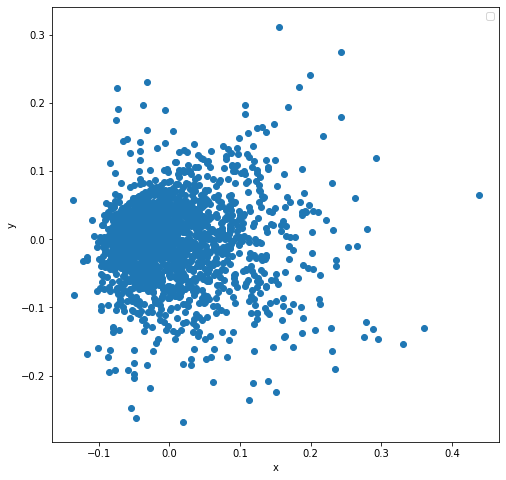

,0,1
"우수수,다한,건드리다,떠나가다,담다,",0.006805,-0.072647
"가을비,버리다,자정,떨다,지나,",0.080098,-0.107065
"비어,보내다,잉크,원고지,백지,",0.010404,-0.099607
"가을,일이,여행,수선스럽다,찬찬하다,",0.042243,-0.093778
"가을,가지런하다,엉금엉금,그립다,새털구름,",0.022632,-0.107372


In [ ]:
pca = PCA(n_components=2)

poem_pca = pd.DataFrame(pca.fit_transform(df), index=df.index)
plt.figure(figsize=(8, 8))
plt.scatter(poem_pca[0], poem_pca[1])
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
poem_pca.head()

No handles with labels found to put in legend.


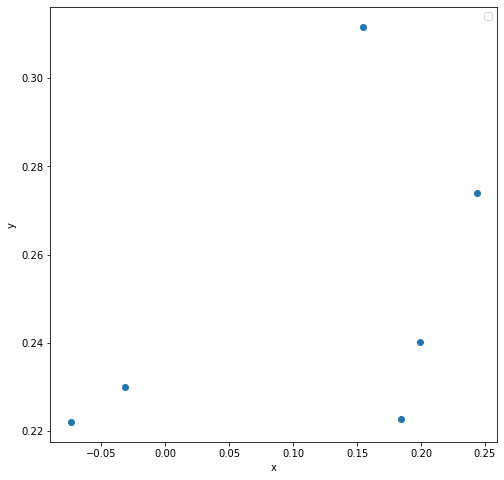

,0,1
"희생,좋다,대가,나르다,비로소,",0.183980,0.222655
"좋다,형편,가지다,어떠하다,용서,",0.243418,0.273891
"그녀,지금,항상,좋아하다,다니다,",-0.031104,0.230002
"좋다,바다,하늘,",0.199088,0.240277
"그녀,친구,좋다,이별,혹시,",0.154865,0.311656
"그녀,남남,콧등,베트남,인조,",-0.073814,0.222078


In [ ]:
poem_pca_y_high = poem_pca[(poem_pca[1] >= 0.2)]
plt.figure(figsize=(8, 8))
plt.scatter(poem_pca_y_high[0], poem_pca_y_high[1])
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()
poem_pca_y_high

No handles with labels found to put in legend.


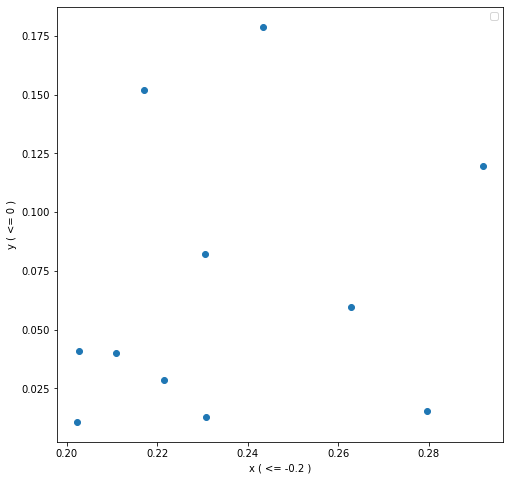

,0,1
"좋다,친구,살피,서로,한아름,",0.243317,0.178888
"설레다,천사도,나쁘다,속삭이다,마음,",0.202302,0.010737
"이기,친구,만남,주다,의미,",0.230546,0.082373
"가장,생각,아름다워지다,저리다,살다,",0.217078,0.152081
"잊다,대로,생각,사노라면,나다,",0.202662,0.040842
"좋다,이면,자신,지혜,마음,",0.291970,0.119722
"행복하다,정다운,어지럽히다,어떠하다,수만,",0.262923,0.059772
"소중하다,아름답다,가장,갖다,보이지,",0.279636,0.015606
"친구,짤막하다,좌절,응답,주기,",0.210819,0.039984
"행복하다,적지,나누다,사이,좋다,",0.221534,0.028759


In [ ]:
poem_pca_xy_middle = poem_pca[
    (poem_pca[0] >= 0.2) & (poem_pca[0] <= 0.4) & (poem_pca[1] >= 0) & (poem_pca[1] <= 0.2)
]
plt.figure(figsize=(8, 8))
plt.scatter(poem_pca_xy_middle[0], poem_pca_xy_middle[1])
plt.legend()
plt.xlabel("x ( <= -0.2 )")
plt.ylabel("y ( <= 0 )")
plt.show()
poem_pca_xy_middle

No handles with labels found to put in legend.


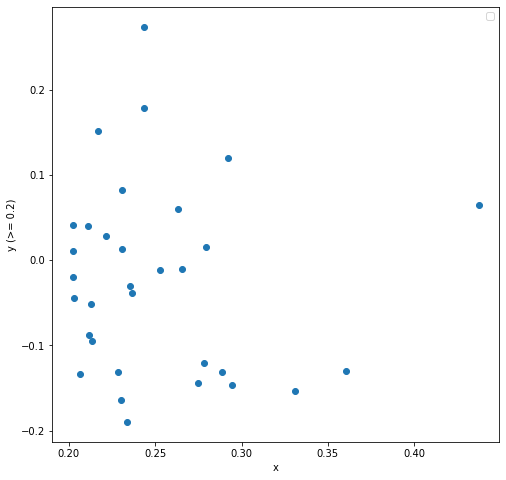

,0,1
"모습,가꾸다,살리다,가슴속,틀다,",0.211396,-0.088177
"잊다,상처,풋사랑,그립다,낫다,",0.228438,-0.130797
"깊숙하다,마음,꽃씨,영토,주다,",0.229995,-0.164244
"행복하다,바라보다,앞날,가르치다,가지런하다,",0.235415,-0.029950
"그립다,아프다,살다,모르다,버리다,",0.294665,-0.145966
"한가지,변치,살다,거꾸로,비록,",0.236370,-0.038658
"좋다,형편,가지다,어떠하다,용서,",0.243418,0.273891
"좋다,친구,살피,서로,한아름,",0.243317,0.178888
"그리움,자기,그립다,방법,예외,",0.278440,-0.120922
"설레다,천사도,나쁘다,속삭이다,마음,",0.202302,0.010737


In [ ]:
poem_pca_x_big = poem_pca[(poem_pca[0] >= 0.2)]
plt.figure(figsize=(8, 8))
plt.scatter(poem_pca_x_big[0], poem_pca_x_big[1])
plt.legend()
plt.xlabel('x')
plt.ylabel('y (>= 0.2)')
plt.show()
poem_pca_x_big

## 4-2. 3차원

In [ ]:
import plotly.express as px

pca = PCA(n_components=3)
poem_pca3d = pd.DataFrame(pca.fit_transform(df), index=df.index)

fig = px.scatter_3d(poem_pca3d, x=0, y=1, z=2)
fig.show()


In [ ]:
poem_pca_z_middel = poem_pca3d[(poem_pca3d[2] >= 0.3)]

# 정렬이 0~2가 아니라 그녀, 좋다에서 되고 있음. 수정 필요.
poem_pca_z_middel.sort_values(by=2, ascending=True)

,0,1,2
"좋다,이면,자신,지혜,마음,",0.290481,0.128697,0.303427
"좋다,풀꽃,붉다,물들다,스마,",0.057404,0.133774,0.308223
"좋다,내리다,창밖,나단조,때절,",0.104718,0.104431,0.317243
"좋다,보아,절망,먼저,답안,",0.110561,0.154232,0.325458
"좋다,마을,담다,가슴,이야기,",0.186845,0.111726,0.325572
"좋다,사이,휘둥그레,등등,새벽이슬,",0.033433,0.149639,0.327108
"좋다,상이,그냥,흐르다,그대로,",0.148377,0.119917,0.347828
"좋다,차다,는걸,사람인,더없이,",0.134786,0.163278,0.359072
"마음,좋다,마음속,생각,세상,",0.437213,0.064895,0.377710
"좋다,친구,살피,서로,한아름,",0.241766,0.183256,0.401803
